In [1]:
# Starts the autoreload extension, which allows editing the .py files with the notebook running and automatically imports the latest changes

%load_ext autoreload
%autoreload 2

import trim_duplicates, model, network, gradcam, plots
from dataset import Dataset
import haiku as hk
import jax.numpy as jnp
import numpy as np
import jax
import sklearn
import wandb

assert jax.local_device_count() >= 8

NUM_CLASSES = 4
SEED = 12
BATCH_SIZE = 128

def basemodel_process(x): return x

In [2]:
rng = jax.random.PRNGKey(SEED)
dataset_mendeley = Dataset.load("mendeley", rng=rng)
dataset_tawsifur = Dataset.load("tawsifur", rng=rng)
print("Loaded mendeley", dataset_mendeley.classnames)
print("Loaded tawsifur", dataset_tawsifur.classnames)

tcmalloc: large alloc 7241465856 bytes == 0x88282000 @  0x7f2867ad8680 0x7f2867af9824 0x7f285d91f4ce 0x7f285d97500e 0x7f285d975c4f 0x7f285da17924 0x5f5db9 0x5f698e 0x57195c 0x56a0ba 0x5f6343 0x56cf2a 0x56a0ba 0x5f6343 0x570e46 0x56a0ba 0x5f6343 0x56cf2a 0x56a0ba 0x68d5b7 0x600f54 0x5c5530 0x56bddd 0x5004f8 0x56d80c 0x5004f8 0x56d80c 0x5004f8 0x5042c6 0x56bf09 0x5f6166
tcmalloc: large alloc 7241465856 bytes == 0x241a76000 @  0x7f2867ad8680 0x7f2867af9824 0x7f2867af9b8a 0x7f263ffe46b7 0x7f263acdb790 0x7f263acea414 0x7f263aced287 0x7f263ac38f0f 0x7f263a9aabe8 0x7f263a997166 0x5f5db9 0x5f698e 0x50b4c7 0x570e46 0x56a0ba 0x5f70bb 0x66600d 0x5f574e 0x56d5f6 0x56a0ba 0x5f6343 0x5f70f7 0x66600d 0x5f574e 0x56d5f6 0x5f6166 0x56bf09 0x56a0ba 0x50adf0 0x56cf2a 0x56a0ba
tcmalloc: large alloc 7241465856 bytes == 0x3f3c3e000 @  0x7f2867ad8680 0x7f2867af9824 0x7f2867af9b8a 0x7f263ffe46b7 0x7f263acdb790 0x7f263acea414 0x7f263aced287 0x7f263ac38f0f 0x7f263a9aabe8 0x7f263a997166 0x5f5db9 0x5f698e 0x50b4c7

Loaded mendeley ['Normal', 'Viral pneumonia', 'COVID-19', 'Pneumonia bacterial']
Loaded tawsifur ['Normal', 'Viral pneumonia', 'COVID-19', 'Lung opacity']


In [3]:
net, optim = model.init_net_and_optim(dataset_mendeley.x_train, NUM_CLASSES, BATCH_SIZE)

# Gets functions for the model
net_container = network.create(net, optim, BATCH_SIZE, shape = (10, 256, 256, 3))

In [4]:
def five_fold_cross_validation(model_name, original_dataset, process_fn, seed=12, num_epochs=30):
    config = { 'dataset' : original_dataset.name,
               'random_seed' : seed,
               'batch_size' : BATCH_SIZE,
               'resolution' : 256 }

    group = model_name + '_CV'

    for i in range(5):
        job_type = 'train_and_eval'
        # RUN 1: Train and eval
        run = wandb.init(project='xrays', entity='usp-covid-xrays',
                         group=group,
                         job_type=job_type,
                         name=model_name + "_CV_" + str(i),
                         reinit=True, config = config)

        cv_dataset = original_dataset.five_fold(i)

        trained = model.train_model(model_name + "_CV" + str(i),
                          net_container, process_fn,
                          cv_dataset, masks = None,
                          num_epochs = num_epochs,
                          wandb_run=run)

        run.finish()

        # RUN 2: Remove duplicates
        run2 = wandb.init(project='xrays', entity='usp-covid-xrays',
                         group=group,
                         job_type='duplicate_removal',
                         name='duprem_' + model_name + "_CV_" + str(i),
                         reinit=True, config = config)
        
        sims = trim_duplicates.compute_similarities(cv_dataset, net_container, trained)
        cv_dataset_curated = trim_duplicates.remove_duplicates(cv_dataset, sims)

        train_before = cv_dataset.x_train.shape[0]
        test_before = cv_dataset.x_test.shape[0]
        
        train_after = cv_dataset_curated.x_train.shape[0]
        test_after = cv_dataset_curated.x_test.shape[0]

        run2.log({
            "train-before": train_before,
            "test-before": test_before,
            "train-duplicates": train_before - train_after,
            "test-duplicates": test_before - test_after,
            "train-after": train_after,
            "test-after": test_after
        })

        run2.finish()

        # RUN 3: Re-train and re-eval
        run3 = wandb.init(project='xrays', entity='usp-covid-xrays',
                         group=group,
                         job_type=job_type + '_nodups',
                         name='nodups_' + model_name + "_CV_" + str(i),
                         reinit=True, config = config)

        model.train_model('nodups_' + model_name + "_CV" + str(i),
                          net_container, process_fn,
                          cv_dataset_curated, masks = None,
                          num_epochs = num_epochs,
                          wandb_run=run3)

        run3.finish()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pedromartelleto (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


tcmalloc: large alloc 5793644544 bytes == 0xebfefe000 @  0x7f2867ad8680 0x7f2867af9824 0x7f2867af9b8a 0x7f263ffe46b7 0x7f263acdb790 0x7f263acea414 0x7f263aced287 0x7f263ac38f0f 0x7f263a9aabe8 0x7f263a997166 0x5f5db9 0x5f698e 0x50b4c7 0x570e46 0x56a0ba 0x5f70bb 0x66600d 0x5f574e 0x56d5f6 0x56a0ba 0x5f6343 0x5f70f7 0x66600d 0x5f574e 0x56d5f6 0x5f6166 0x56bf09 0x56a0ba 0x50adf0 0x56cf2a 0x56a0ba
tcmalloc: large alloc 5793644544 bytes == 0x101943e000 @  0x7f2867ad8680 0x7f2867af9824 0x7f2867af9b8a 0x7f263ffe46b7 0x7f263acdb790 0x7f263acea414 0x7f263aced287 0x7f263ac38f0f 0x7f263a9aabe8 0x7f263a997166 0x5f5db9 0x5f698e 0x50b4c7 0x570e46 0x56a0ba 0x5f70bb 0x66600d 0x5f574e 0x56d5f6 0x56a0ba 0x5f6343 0x5f70f7 0x66600d 0x5f574e 0x56d5f6 0x5f6166 0x56bf09 0x56a0ba 0x50adf0 0x56cf2a 0x5f6166
tcmalloc: large alloc 7241465856 bytes == 0x12a10be000 @  0x7f2867ad8680 0x7f2867af9824 0x7f2867af9b8a 0x7f263ffe46b7 0x7f263acdb790 0x7f263acea414 0x7f263aced287 0x7f263ac38f0f 0x7f263a9aabe8 0x7f263a997166

Model loaded from models/base_mendeley_CV0.pickle


wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Calculating embeddings...


100%|███████████████████████████████████████████████████████████████████████████████████| 71/71 [00:27<00:00,  2.54it/s]
tcmalloc: large alloc 9529458688 bytes == 0x14512be000 @  0x7f2867ad8680 0x7f2867af9824 0x7f2867af9b8a 0x7f263ffe46b7 0x7f263acdb790 0x7f263acea414 0x7f263aced287 0x7f263ac38f0f 0x7f263a9aabe8 0x7f263a997166 0x5f5db9 0x5f698e 0x50b4c7 0x570e46 0x56a0ba 0x5f70bb 0x66600d 0x5f574e 0x56d5f6 0x56a0ba 0x5f6343 0x5f70f7 0x66600d 0x5f574e 0x56d5f6 0x5f6166 0x56bf09 0x56a0ba 0x5f6343 0x50b291 0x5f56c7
tcmalloc: large alloc 9529458688 bytes == 0x1689abe000 @  0x7f2867ad8680 0x7f2867af9824 0x7f2867af9b8a 0x7f263ffe46b7 0x7f263acdb790 0x7f263acea414 0x7f263aced287 0x7f263ac38f0f 0x7f263a9aabe8 0x7f263a997166 0x5f5db9 0x5f698e 0x50b4c7 0x570e46 0x56a0ba 0x5f70bb 0x66600d 0x5f574e 0x56d5f6 0x56a0ba 0x5f6343 0x5f70f7 0x66600d 0x5f574e 0x56d5f6 0x5f6166 0x56bf09 0x56a0ba 0x50adf0 0x56cf2a 0x56a0ba


Computing cosine similarities...


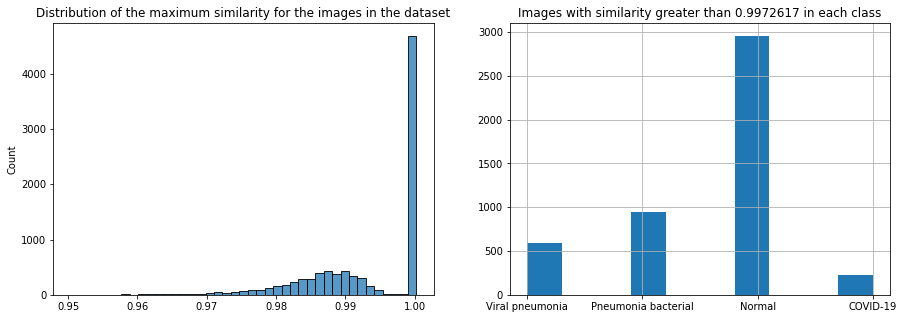

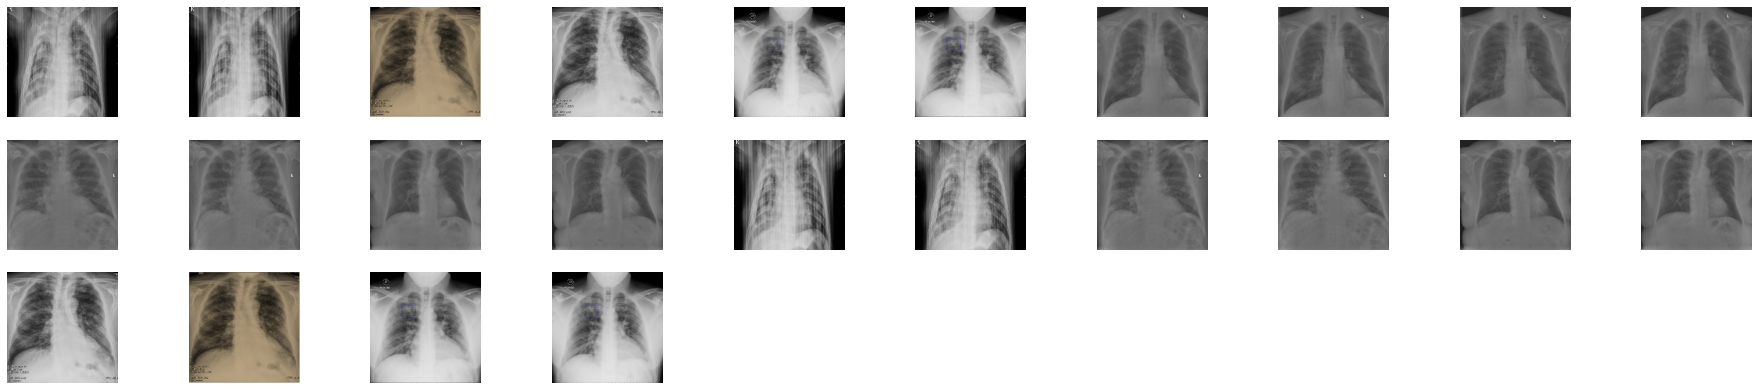

THRESH ALGORITHM OUTPUT 0.9972617


100%|██████████| 9208/9208 [00:27<00:00, 329.27it/s]


trim_duplicates.remove_duplicates - Removed images: 2576 (28.0%)


test-after,▁
test-before,▁
test-duplicates,▁
train-after,▁
train-before,▁
train-duplicates,▁
test-after,1729
test-before,1841
test-duplicates,112
train-after,4903
train-before,7367


wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


100%|█████████████████████████████████| 38/38 [00:04<00:00,  8.31it/s, loss=0.22, acc=0.91, val_loss=0.51, val_acc=0.82]


Model saved to models/nodups_base_mendeley_CV0.pickle


acc,▂▂▁▂▂▃▃▃▄▄▅▅▅▅▆▆▆▇▇▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███
loss,█▇▇██▇▇▇▆▅▅▄▄▄▃▃▄▂▂▂▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁
val_acc,▁▁▁▃▄▄▅▆▆▇▇▇▇█▇▇▇█████████████
val_loss,███▇▇▆▅▄▃▂▂▂▂▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁
acc,0.92969
loss,0.21389
val_acc,0.81791
val_loss,0.50913


wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Model loaded from models/base_mendeley_CV1.pickle


wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Calculating embeddings...


100%|███████████████████████████████████████████████████████████████████████████████████| 71/71 [00:27<00:00,  2.61it/s]
tcmalloc: large alloc 9529458688 bytes == 0x14512be000 @  0x7f2867ad8680 0x7f2867af9824 0x7f2867af9b8a 0x7f263ffe46b7 0x7f263acdb790 0x7f263acea414 0x7f263aced287 0x7f263ac38f0f 0x7f263a9aabe8 0x7f263a997166 0x5f5db9 0x5f698e 0x50b4c7 0x570e46 0x56a0ba 0x5f70bb 0x66600d 0x5f574e 0x56d5f6 0x56a0ba 0x5f6343 0x5f70f7 0x66600d 0x5f574e 0x56d5f6 0x5f6166 0x56bf09 0x56a0ba 0x5f6343 0x50b291 0x5f56c7
tcmalloc: large alloc 9529458688 bytes == 0x1a72cbe000 @  0x7f2867ad8680 0x7f2867af9824 0x7f2867af9b8a 0x7f263ffe46b7 0x7f263acdb790 0x7f263acea414 0x7f263aced287 0x7f263ac38f0f 0x7f263a9aabe8 0x7f263a997166 0x5f5db9 0x5f698e 0x50b4c7 0x570e46 0x56a0ba 0x5f70bb 0x66600d 0x5f574e 0x56d5f6 0x56a0ba 0x5f6343 0x5f70f7 0x66600d 0x5f574e 0x56d5f6 0x5f6166 0x56bf09 0x56a0ba 0x50adf0 0x56cf2a 0x56a0ba


Computing cosine similarities...


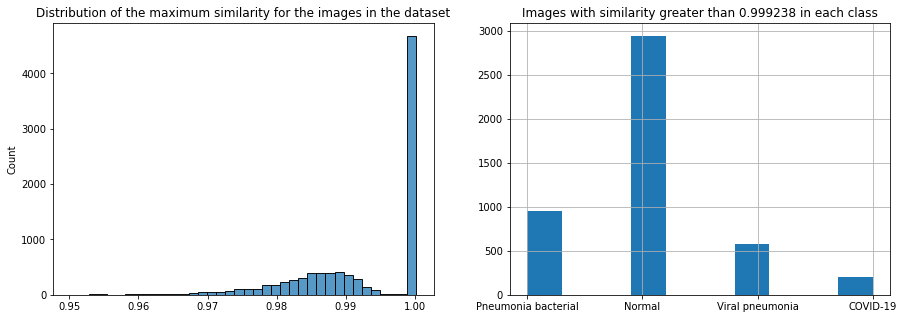

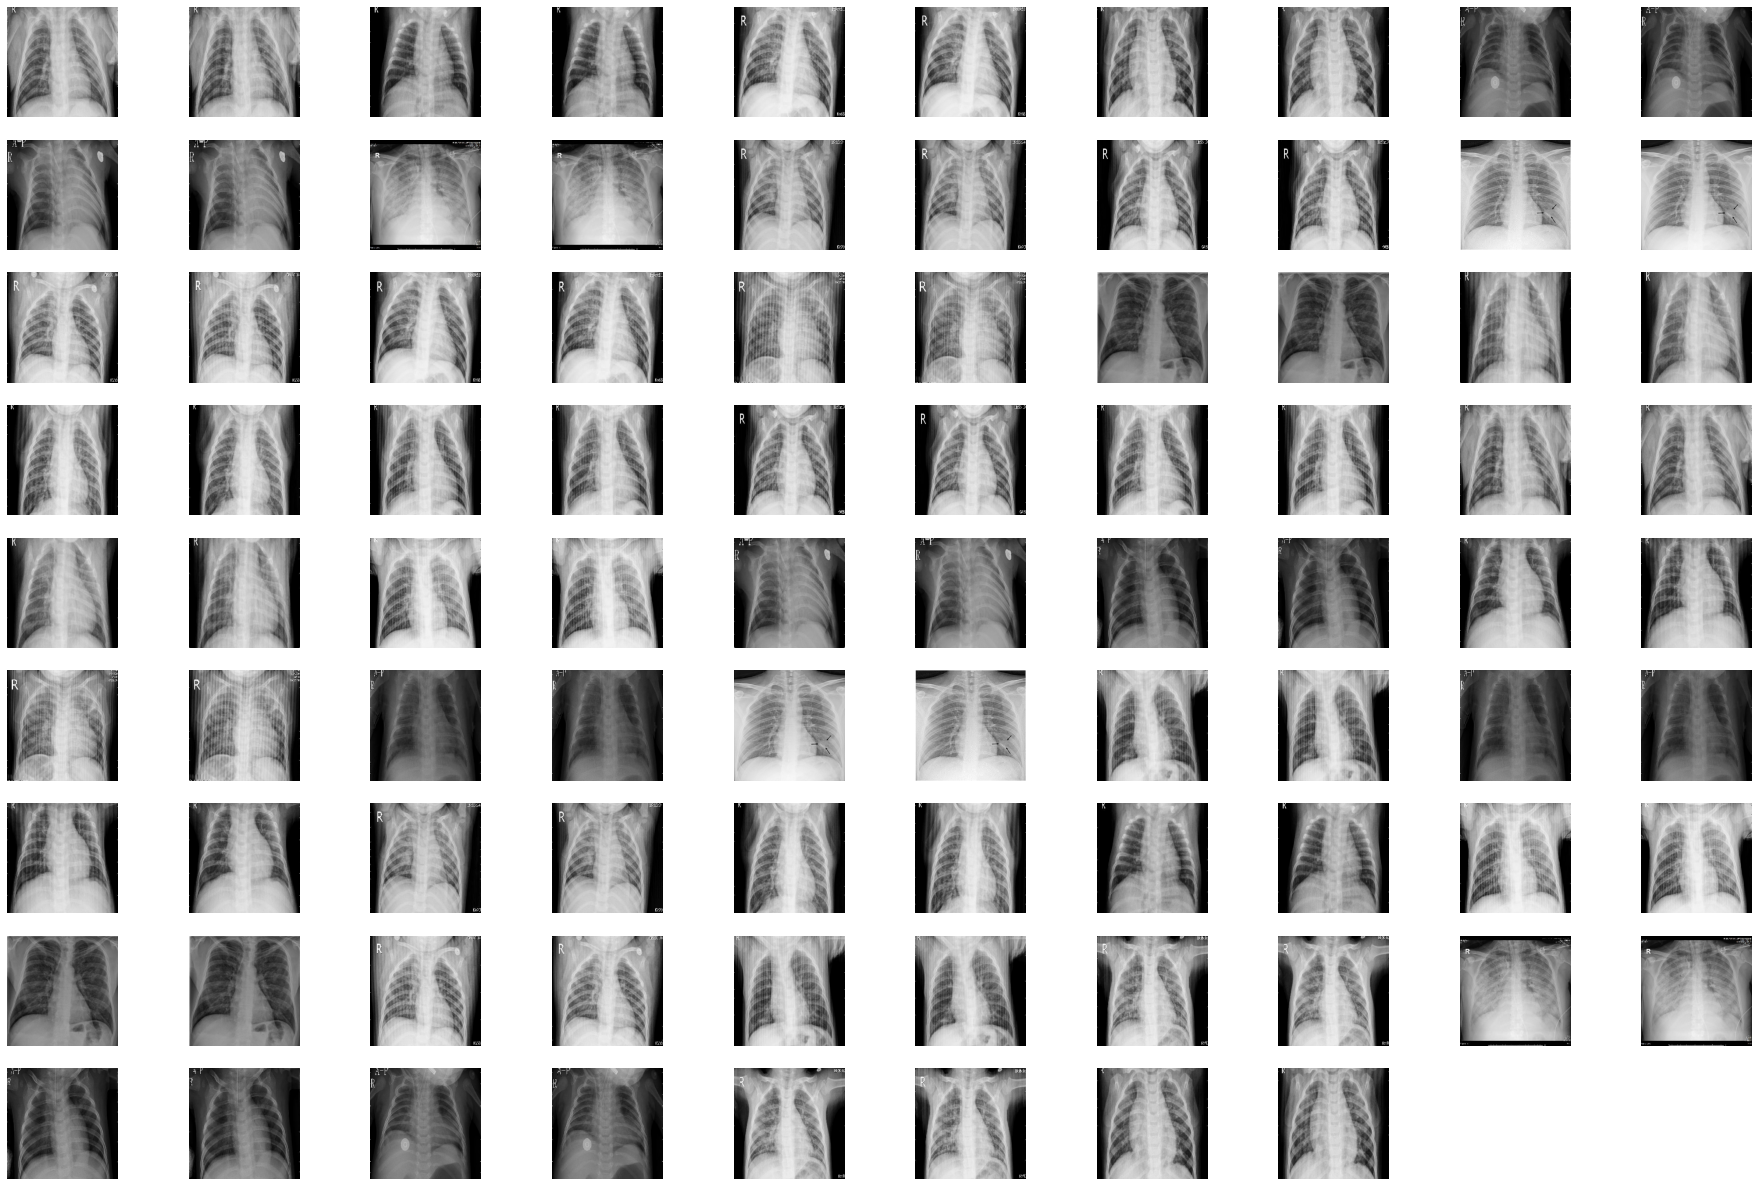

THRESH ALGORITHM OUTPUT 0.999238


100%|██████████| 9208/9208 [00:28<00:00, 320.66it/s]


trim_duplicates.remove_duplicates - Removed images: 2550 (27.7%)


test-after,▁
test-before,▁
test-duplicates,▁
train-after,▁
train-before,▁
train-duplicates,▁
test-after,1723
test-before,1841
test-duplicates,118
train-after,4935
train-before,7367


wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


 71%|████████████████████████████████████████████                  | 27/38 [00:02<00:00, 12.37it/s, loss=0.28, acc=0.89]

In [5]:
dup_thresholds = {
    'mendeley': 0.99,
    'tawsifur': 0.998
}
assert jax.local_device_count() >= 8
five_fold_cross_validation("base_mendeley", dataset_mendeley, basemodel_process, num_epochs=30)
#five_fold_cross_validation("base_tawsifur", dataset_tawsifur, basemodel_process, num_epochs=30)

In [ ]:
basemodel_tawsifur = model.train_model(model_name + "CV" + str(i), net_container, process_fn, cv_dataset)
sims = trim_duplicates.compute_similarities(dataset_tawsifur, net_container, basemodel_tawsifur)

In [ ]:
thresh = 0.998
max_sims = sims.max(axis=1) - thresh
y_classes = dataset_tawsifur.y_all[:sims.shape[0]].argmax(1)
max_sims_index = sims.argmax(axis=1)
mask = (max_sims >= 0) & (max_sims <= 0.0005)
indices = np.where(mask)[0]
plots.compare_images(dataset_tawsifur.x_all[indices], dataset_tawsifur.x_all[max_sims_index[indices]], rows=10)
#trim_duplicates.plot_similarities(dataset_tawsifur, sims, threshold=0.99)

In [ ]:
trim_duplicates.plot_similarities(dataset_tawsifur, sims, threshold=thresh)
dataset_tawsifur_curated = trim_duplicates.remove_duplicates(dataset_tawsifur, sims, threshold=thresh)

In [ ]:
print(dataset_tawsifur_curated.x_train.shape, dataset_tawsifur.x_train.shape)

In [ ]:
basemodel_tawsifur_curated = model.train_model("basemodel_tawsifur_curated", net_container, basemodel_process, dataset_tawsifur_curated)
y_pred_tawsifur_curated = net_container.predict(basemodel_tawsifur_curated.params, basemodel_tawsifur_curated.state, dataset_tawsifur_curated.x_test)
plots.confusion_matrix(dataset_tawsifur_curated, y_pred_tawsifur_curated, "Tawsifur - Curated")

# Transfer learning test

In [ ]:
rng = jax.random.PRNGKey(SEED)
dataset_mendeley = Dataset.load("mendeley", rng=rng)

net, optim = model.init_net_and_optim(dataset_mendeley.x_train, NUM_CLASSES, BATCH_SIZE)

# Gets functions for the model
net_container = network.create(net, optim, BATCH_SIZE, shape = (10, 256, 256, 3))

In [ ]:
# Test of tawsifur on mendeley

basemodel_tawsifur = model.train_model("basemodel_tawsifurCV0", net_container, basemodel_process, dataset_mendeley)
y_test_pred = net_container.predict(basemodel_tawsifur.params, basemodel_tawsifur.state, dataset_mendeley.x_test)
matrix = sklearn.metrics.confusion_matrix(
        dataset_mendeley.y_test[0:y_test_pred.shape[0],].argmax(1),
        y_test_pred.argmax(1), normalize = 'true'
    )
plots.heatmatrix(matrix, "Transfer learning from tawsifur to mendeley")